# Magnipy Tutorial

This tutorial will walk you through using some of the main functionalities of the `Magnipy` class, which is used to **compute and compare the magnitude (effective size) of point clouds.**

## Importing Packages and Datasets

Before we begin, we must import the required packages. Please ensure that you have activated your virtual environment and installed the dependencies using poetry before this step (see **Dependencies** in the README).

In [1]:
# import statements for external packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
# import statements from magnipy repo
from magnipy.magnipy import Magnipy
from magnipy.utils.tutorial_data import get_random, get_clusters, get_swiss_roll, plot_dfs, plot_matrix_heatmaps, plot_weights, show_magnitude_table

We create 3 example datasets according to different distributions, each with 1000 points.

1. **Random Point Cloud from Uniform Distribution:** We generate random points in a 3D space (i.e. selecting points according to a uniform distribution.)

2. **Clusters/Blobs:** We generate a dataset of multiple Gaussian blobs clustered around 5 center points.

3. **The Swiss Roll:** We sample points on a Swiss Roll, a space that takes the shape of a 2D plane that has been rolled up forming a 3D manifold. 

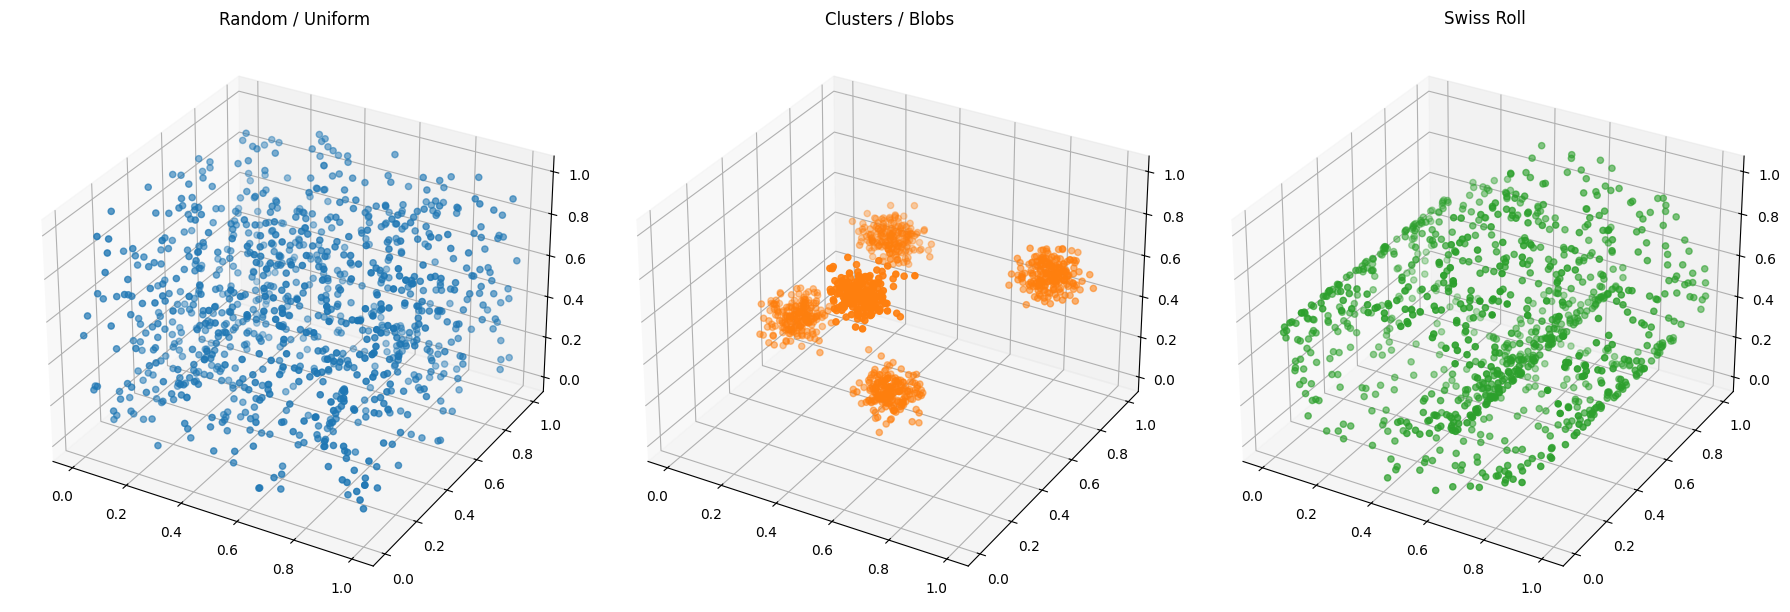

In [2]:
# Grabbing datasets
rando_data, rando_df = get_random()
blobs_data, blobs_df = get_clusters()
sr_data, sr_df = get_swiss_roll()

# Plotting
plot_dfs([rando_df, blobs_df, sr_df], titles=["Random / Uniform", "Clusters / Blobs", "Swiss Roll"])

## Computing Magnitude

To compute magnitude, we first create the `Magnipy` object for each datset, which we will use to call our magnitude methods.

In [3]:
# Creating a Magnipy instance for each dataset
rando = Magnipy(rando_data, name='Random')
blobs = Magnipy(blobs_data, name='Clustered/Blobs')
swiss_roll = Magnipy(sr_data, name='Swiss Roll')
mags = [rando, blobs, swiss_roll]

We can now compute magnitude for each of these instances. Computing and visualizing the magnitude function across distance scales is as simple as calling the `get_magnitude()` method.

In [9]:
# Computing magnitude functions
for mag in mags:
    mag_values, ts = mag.get_magnitude()
    print(f"{mag._name} magnitude values: {mag_values}")
    print(f"{mag._name} evaluation scales: {ts}")
    print()

Random magnitude values: [  1.           7.31169343  21.63793963  46.55296608  83.82828527
 133.82294628 195.09885766 264.5792118  338.25464806 412.10297187
 482.81998057 548.15959791 606.92124793 658.73732856 703.80519997
 742.64939565 775.94558529 804.40591583 828.71257245 849.48451479
 867.26494018 882.52060259 895.64722868 906.97755095 916.78999249
 925.31698042 932.75242118 939.25818183 944.96958472 950.00000005]
Random evaluation scales: [0.         0.25927989 0.51855977 0.77783966 1.03711955 1.29639944
 1.55567932 1.81495921 2.0742391  2.33351898 2.59279887 2.85207876
 3.11135865 3.37063853 3.62991842 3.88919831 4.14847819 4.40775808
 4.66703797 4.92631786 5.18559774 5.44487763 5.70415752 5.9634374
 6.22271729 6.48199718 6.74127707 7.00055695 7.25983684 7.51911673]

Clustered/Blobs magnitude values: [  1.          18.26939784  47.04752452  87.08867253 137.71728764
 196.73437654 261.30274206 328.52434058 395.78103049 460.91729144
 522.32082093 578.92806952 630.17177419 675.890426

Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

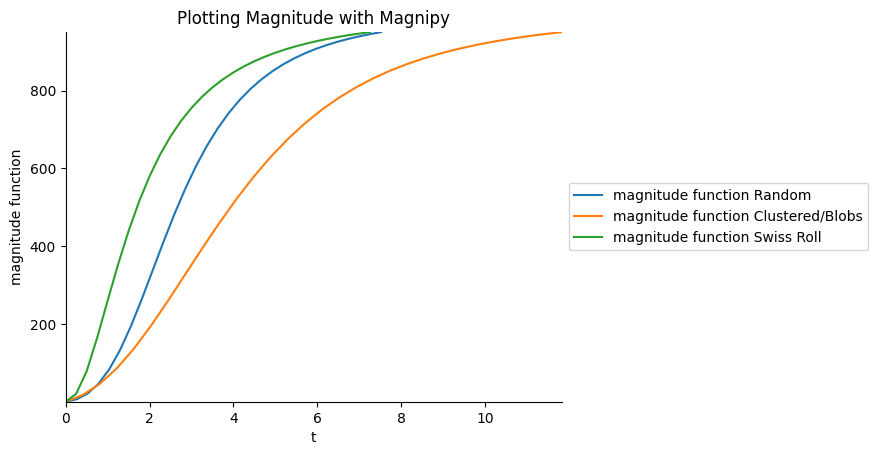

In [10]:
# Plotting the magnitude functions
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

Recall that **t** is our distance scaling factor. Pairwise distances between points are scaled by a factor of **t**. We can visualize an increase in **t** as 'zooming in', so that points move further away from each other.

- For very small **t**, magnitude approaches one. All points are very close and the space effectively resembles only one distinct point.
- As **t** increases, we *zoom in* and the distance between points increases as they spread out. Thus, the magnitude / effective size also increases.
- Finally, magnitude plateaus at the cardinality of the dataset. In this case, magnitude is approaching 1000 for large values of **t**.

By default, we compute magnitude until it reaches 95% of the cardinality. (See section _"Determining Convergence Scales and Evaluation Intervals"_ below).

## Zooming In: Breakdown of Magnitude Pipeline

How does `Magnipy` compute magnitude? In this section, we walk through the process step by step:

1. Computing the Distance Matrix
2. Creating the Similarity Matrix
3. Determining Convergence Scales and Evaluation Intervals
4. Computing Magnitude Weights
5. Computing the Overall Magnitude as the Sum of the Magnitude Weights

### 1. Computing the Distance Matrix

Recall that **t** is a scaling factor for the distance between points in the metric space. We compute a distance matrix that stores the pairwise distances between points in the metric space. (The dimensions of this matrix are $|X|$ by $|X|$).

In [11]:
# Computing distance matrix with get_dist()
rando_dist = rando.get_dist()
blob_dist = blobs.get_dist()
swiss_dist = swiss_roll.get_dist()

We can visualize these distance matrices below, with the x- and y- axes representing the index of each point in the dataset. Note that distance when x=y (i.e. distance between a point and itself) is always 0.

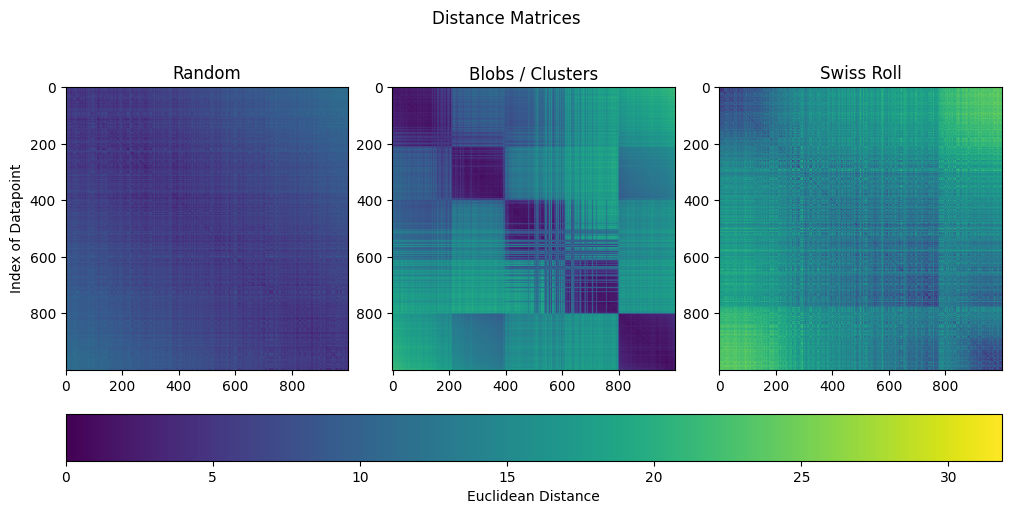

In [8]:
# Visualization of distance matrices
plot_matrix_heatmaps([rando_dist, blob_dist, swiss_dist], distance=True)

##### Customizing Distance Calculation

When initializing the Magnipy object, you can customize which distance metric you want to use. The default is to use *Euclidean* distance. See `magnipy.py` for a complete list of all supported metrics. For example, we could compute *Cityblock* distances instead by changing the `metric` argument.

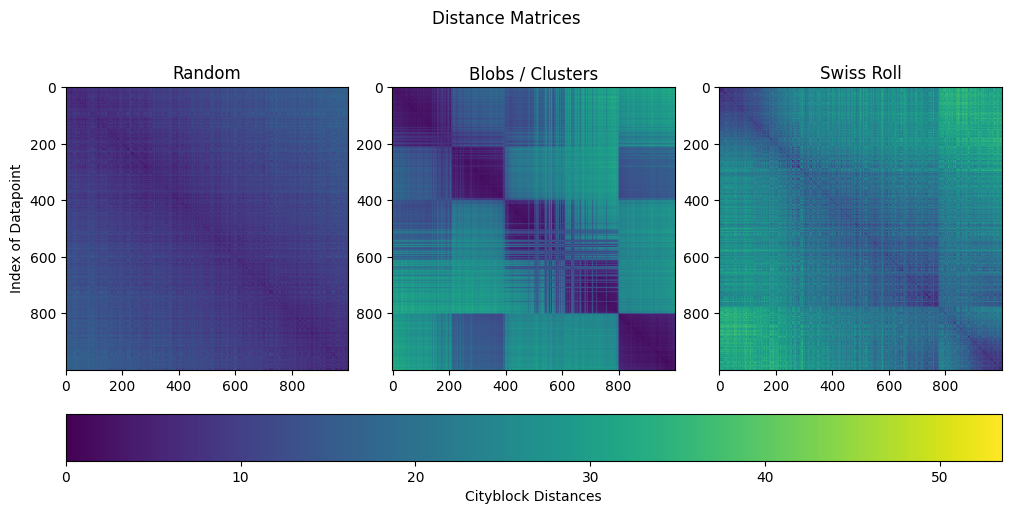

In [9]:
rando = Magnipy(rando_data, name='Random', metric='cityblock')
blobs = Magnipy(blobs_data, name='Clustered/Blobs', metric='cityblock')
swiss_roll = Magnipy(sr_data, name='Swiss Roll', metric='cityblock')
mags_l1 = [rando, blobs, swiss_roll]
dist_l1 = [mag.get_dist() for mag in mags_l1]
plot_matrix_heatmaps(dist_l1, distance=True, metric = "Cityblock Distances")

### 2. Creating the Similarity Matrix

Given a metric space $(X, d)$ and a scaling factor $t$, the distance $d$ and the similarity $\zeta_X$ of two points $x_i, x_j \in X$ are related in the following way: 

$$\zeta_X(t)_{i,j} = e^{-t \cdot d(x_i,x_j)}$$

Practically speaking, this means that two points separated by a distance almost 0 (i.e. they are almost the same) have a **similarity close to 1**. Conversely, two points separated by a large distance approaching infinity have a **similarity approaching 0** i.e. they are almost completely distinct. This relationship, in which **similarities decrease exponentially as distances increase,** emphasizes the influence of close neighbors / very similar pairs of points.

In [10]:
# Computing similarity matrices
rando_sim = rando.get_similarity_matrix()
blobs_sim = blobs.get_similarity_matrix()
swiss_sim = swiss_roll.get_similarity_matrix()

We can visualize these similarity matrices below (for t=1). Recall that for any scale t, **all similarity values fall between 0 and 1**.

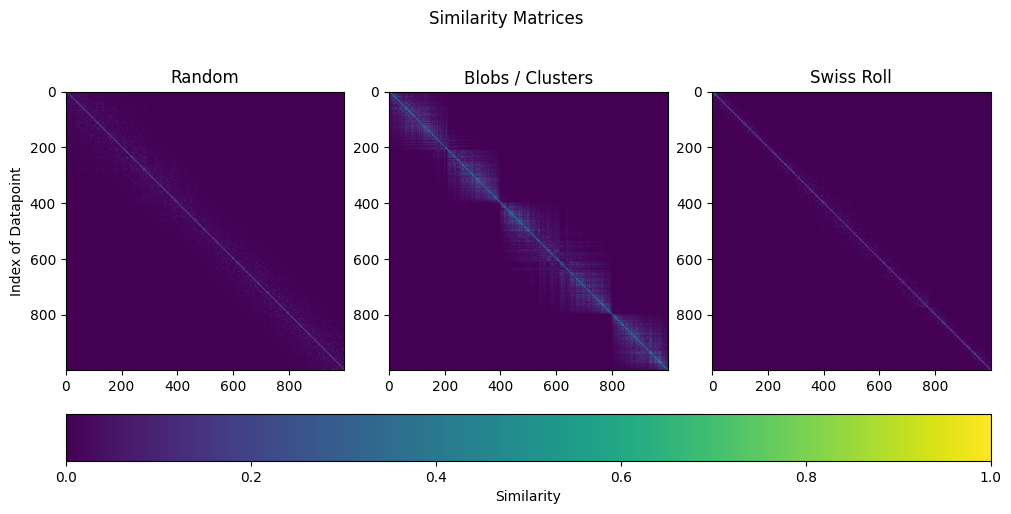

In [11]:
# Visualizing similarity matrices
plot_matrix_heatmaps([rando_sim, blobs_sim, swiss_sim], distance=False)

### 3. Determining Convergence Scales and Evaluation Intervals

**_Q: How does `Magnipy` decide which values of **t** to compute magnitude for?_**  

We define each `Magnipy` object's **evaluation interval** as the range of t values over which magnitude should be calculated. This can be determined automatically by `Magnipy` or be customized by the user.

**Automatic Computation by `Magnipy` (Default)**

`Magnipy` can compute a suitable evaluation interval automatically by taking the interval from zero until the spaces's **convergence scale** (i.e. when the magnitude will reach 95% of the space's cardinality) and dividing it evenly into `n_ts` values (default=30).

In [12]:
# Get evaluation interval for dataset with .get_scales()
rando_ts = rando.get_scales()
print(f"Evaluation interval for Random Dataset: [{rando_ts[0]:.2f}, {rando_ts[1]:.2f}, {rando_ts[2]:.2f}, ..., {rando_ts[-1]:.2f}].")

# Get convergence scale for datasets with .get_t_conv()
rando_conv = rando.get_t_conv()
print(f"Notice that the last value of the evaluation interval is the same as the convergence scale: {rando_conv:.2f}")

Evaluation interval for Random Dataset: [0.00, 0.18, 0.36, ..., 5.16].
Notice that the last value of the evaluation interval is the same as the convergence scale: 5.16


**User Customization**

There are several ways for the user to **customize how evaluation scales are computed** when creating a `Magnipy` object, including:

- Manually entering t values via the `ts` parameter (default = None)
- Altering the number of t values via the `n_ts` parameter (default = 30)
- Using a log scale by setting `log_scale = True` (default = False)
- Changing the proportion of cardinality the magnitude function converges to via `target_prop` (default = 0.95)

See the `magnipy.py` file for descriptions of all evaluation scale parameters.

### 4. Computing Magnitude Weights

Before finding the magnitude of the whole space at each time scale, we first compute the **magnitude weights** for each of point at each time scale. When the inverse of the similarity matrix $\zeta_{X}$ exists, we define the vector of magnitude weights as follows:

$$w_{X}(t) := \zeta_{X}(t)^{-1}\mathbb{I}$$

Here, $\mathbb{I}$ is the $|X| * 1$ column vector of ones. 

The magnitude weight of a point can roughly be thought of **each point's contribution to the overall magnitude**. Magnitude weights have been successfully used for both outlier and boundary detection. Generally, points on boundaries have higher magnitude weights than points on the interior of shapes or clusters. As a point becomes more dissimilar (i.e further) from all surrounding points, i.e. as the scaling factor t increases, the point's magnitude weight converges to one. That is, if all points are far apart, each point effectively looks like one distinct point. Magnitude is then simply computed as the sum of all magnitude weights.

Magnitude weights and thus magnitude can be computed according to several different methods that vary in computational speed and accuracy. You can select your preferred method via the `method` parameter when initializing a Magnipy object (**default = "cholesky"**).

In [13]:
# Computing magnitude weights with get_magnitude_weights() method
rando_weights, rando_ts = rando.get_magnitude_weights()
blobs_weights, blobs_ts = blobs.get_magnitude_weights()
swiss_weights, swiss_ts = swiss_roll.get_magnitude_weights()

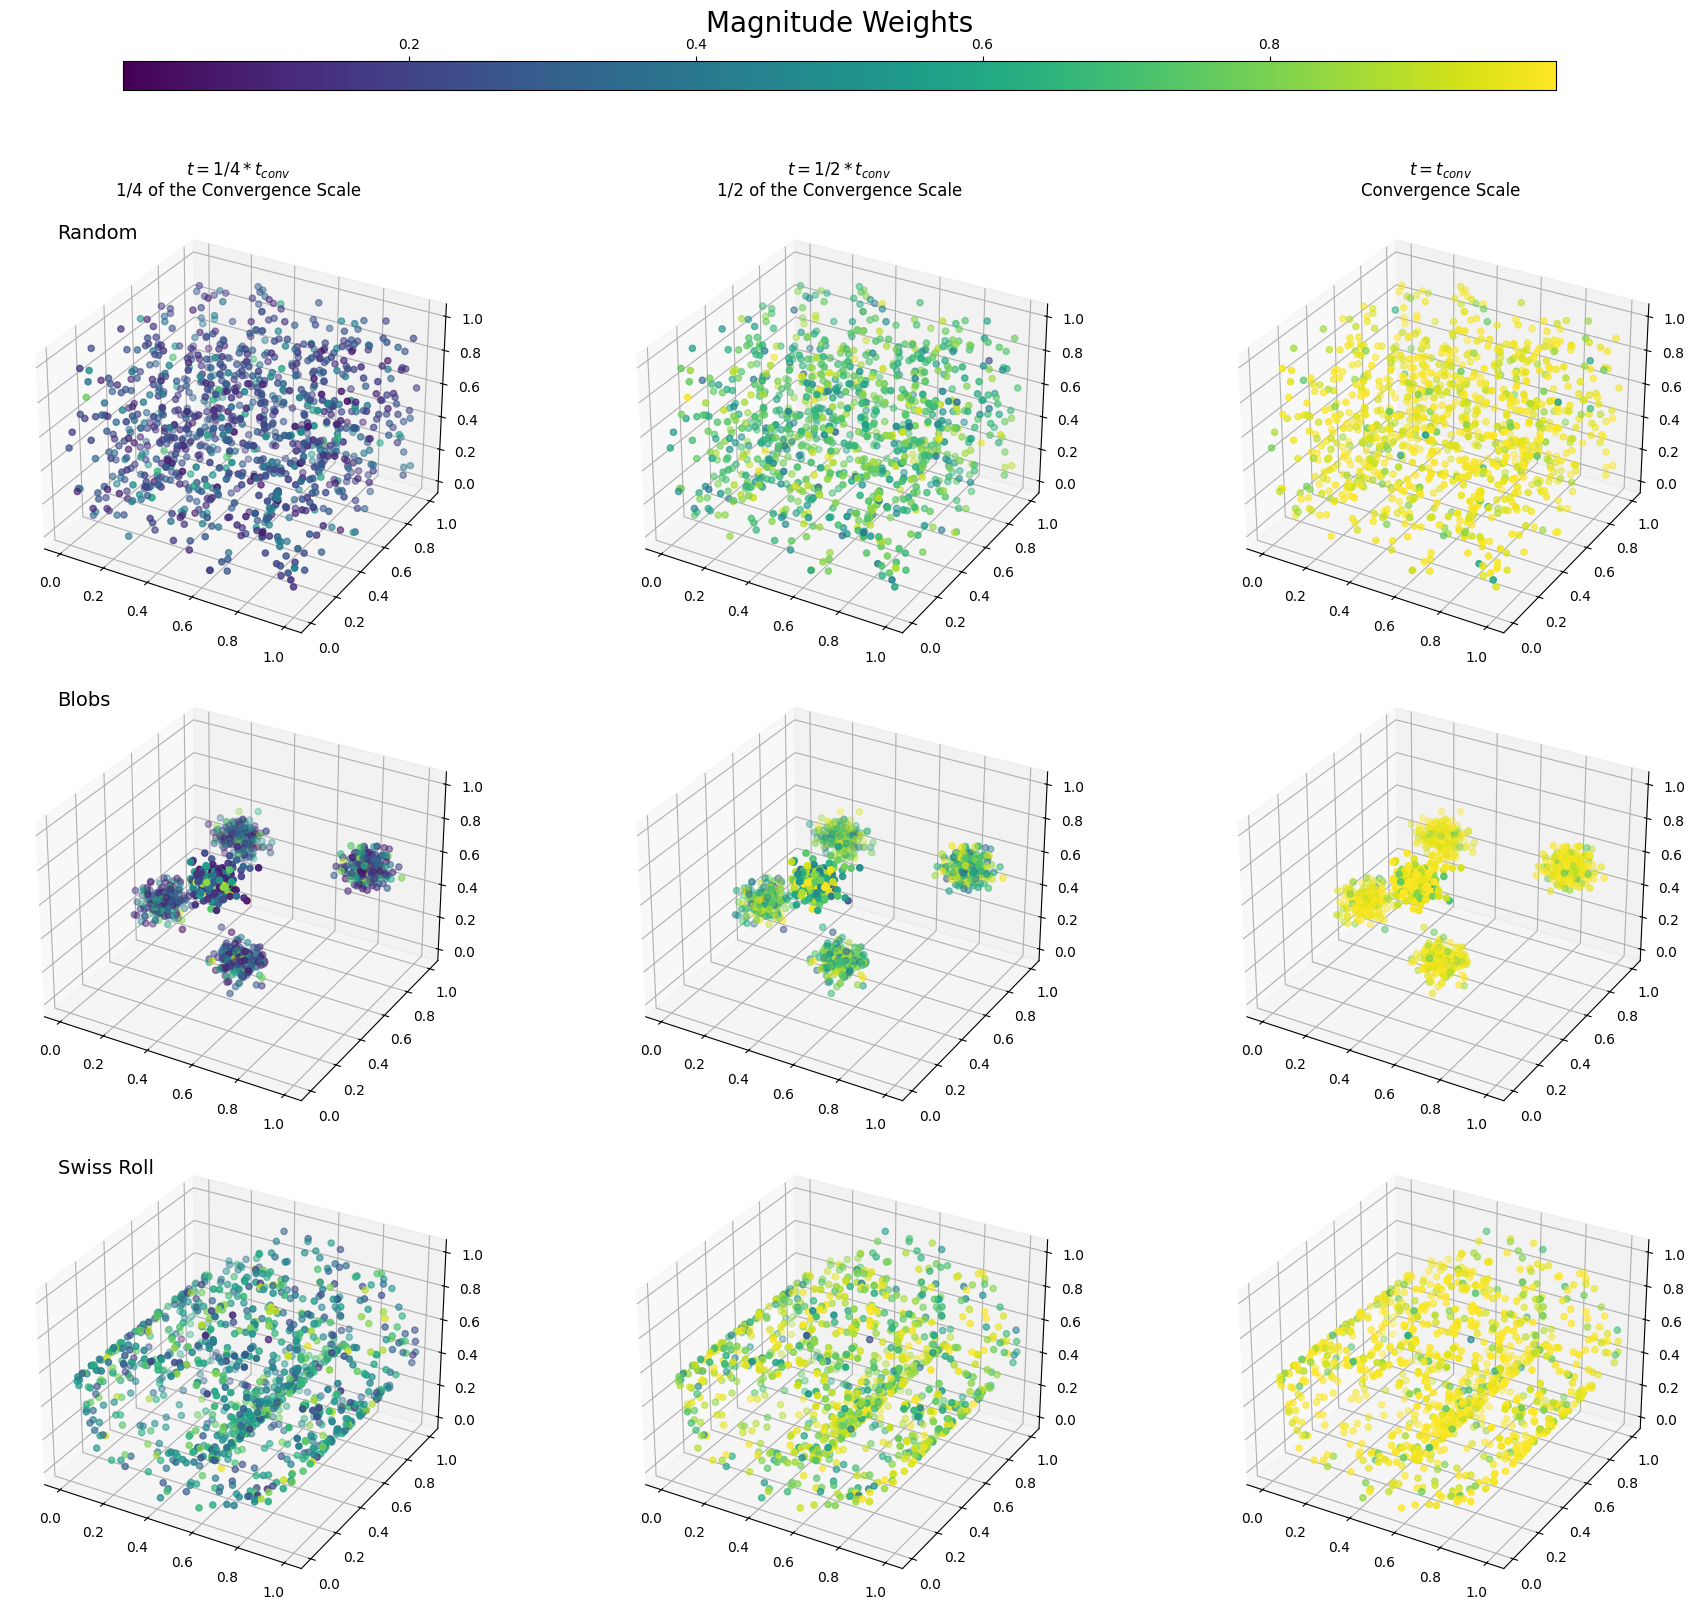

In [14]:
# Plotting magnitude weights
plot_weights(
    [rando_df, blobs_df, sr_df],
    [rando_ts, blobs_ts, swiss_ts],
    [rando_weights, blobs_weights, swiss_weights],
    ["Random", "Blobs", "Swiss Roll"],
)

### 5. Aggregating for Overall Magnitude

If the similarity matrix $\zeta_{i,j}$ of a metric space $X$ is invertible, then we define the **magnitude of $X$** at scaling factor **t** as the sum of entries in the inverted similarity matrix at scaling factor **t**:

$$\text{Mag}_X(t) = \sum_{i,j} (\zeta_X(t)^{-1})_{i,j}$$

Note that this is equivalent to the sum over all the magnitude weights at scaling factor **t**:

$$\text{Mag}_X(t) = \sum_i (w_{X}(t))_i$$

In [15]:
# Getting magnitude values
rando_magnitude_vals, rando_t_vals = rando.get_magnitude()
blobs_magnitude_vals, blobs_t_vals = blobs.get_magnitude()
swiss_magnitude_vals, swiss_t_vals = swiss_roll.get_magnitude()

show_magnitude_table([rando_magnitude_vals, blobs_magnitude_vals, swiss_magnitude_vals], [rando_t_vals, blobs_t_vals, swiss_t_vals])

Random Dataset 		Blobs Dataset 			Swiss Roll Dataset
t 	 Magnitude 	t 	 Magnitude 	t 	 Magnitude
0.00 	 1.00    	0.00 	 1.00     	 0.00 	 1.00
0.18 	 6.48    	0.28 	 18.75     	 0.18 	 21.86
0.36 	 19.89    	0.55 	 47.88     	 0.36 	 81.26
0.53 	 44.17    	0.83 	 88.02     	 0.53 	 167.73
0.71 	 81.27    	1.11 	 138.46     	 0.71 	 263.44
0.89 	 131.54    	1.38 	 197.07     	 0.89 	 356.98
1.07 	 193.39    	1.66 	 261.14     	 1.07 	 442.52
1.24 	 263.58    	1.94 	 327.87     	 1.24 	 517.76
1.42 	 337.96    	2.21 	 394.71     	 1.42 	 582.51
1.60 	 412.41    	2.49 	 459.52     	 1.60 	 637.56
1.78 	 483.57    	2.77 	 520.70     	 1.78 	 684.12
1.96 	 549.21    	3.04 	 577.18     	 1.95 	 723.46
2.13 	 608.14    	3.32 	 628.38     	 2.13 	 756.73
2.31 	 660.01    	3.60 	 674.11     	 2.31 	 784.96
2.49 	 705.06    	3.87 	 714.51     	 2.49 	 809.01
2.67 	 743.84    	4.15 	 749.90     	 2.66 	 829.57
2.84 	 777.03    	4.43 	 780.71     	 2.84 	 847.25
3.02 	 805.38    	4.71 	 807.42    

Here we can confirm that the default evaluation interval computed by Magnipy **stops when the magnitude reaches 95% of the cardinality** (95% of 1000 = 950). These values printed above then represent the magnitude functions plotted previously.

We define the **magnitude function** as follows. Let $(X, d)$ be a metric space and $tX := (X, d_t)$ its scaled version with $d_{t}(x, y) := t · d(x, y)$ for a scaling factor $t ∈ R+$. The magnitude function $X$ is the function $\text{Mag}_X : t → \text{Mag}_{tX}.$

Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

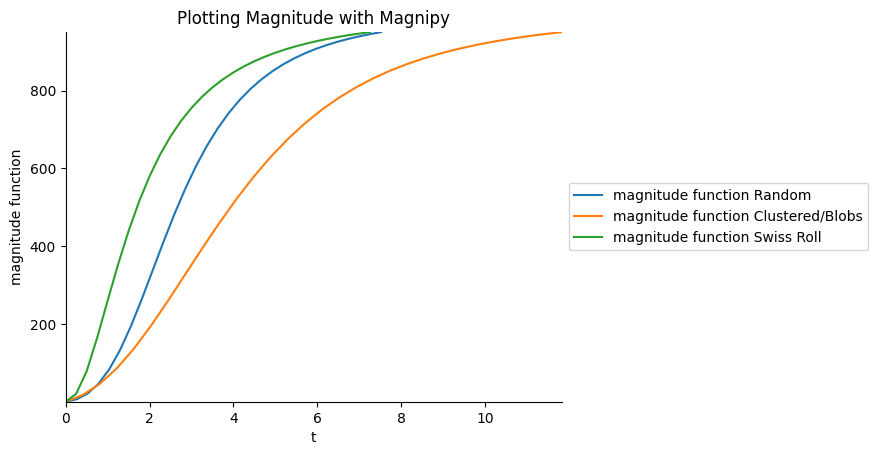

In [16]:
# Plotting magnitude again
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

###  Nice work! We have come full circle.

This concludes the `Magnipy` tutorial. To investigate how magnitude can act as a metric for quantifying the diversity of a metric space, please see our `Diversipy` Tutorial (`diversipy_tutorial.ipynb`).